# Benchmarking lung integration

Here we walkthrough applying the integration benchmarking metrics on the lung atlas example from the [scIB paper](https://www.nature.com/articles/s41592-021-01336-8).

In [ ]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker

%matplotlib inline

## Load and preprocess data

In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [ ]:
adata

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

We subset to the highly variable genes so that each method has the same input.

In [ ]:
adata = adata[:, adata.var.highly_variable].copy()

In [ ]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

Here we run a few embedding-based methods. By focusing on embedding-based methods, we can substantially reduce the runtime of the benchmarking metrics.

In principle, graph-based integration methods can also be benchmarked on some of the metrics that have graph inputs. Future work can explore using graph convolutional networks to embed the graph and then using the embedding-based metrics.

### Scanorama

In [ ]:
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

### Liger

In [ ]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

### Harmony

In [ ]:
from harmony import harmonize

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

### scVI

In [ ]:
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

### scANVI

In [ ]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

## Perform the benchmark

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()

Computing neighbors:  50%|█████     | 3/6 [00:30<00:26,  8.90s/it]

Embeddings: 100%|██████████| 6/6 [02:19<00:00, 23.24s/it]


### Visualize the results

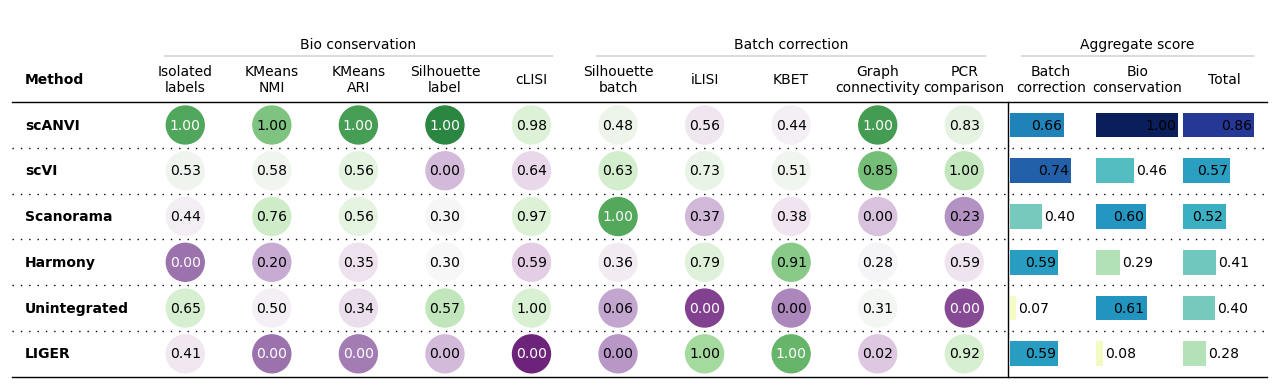

In [ ]:
bm.plot_results_table()

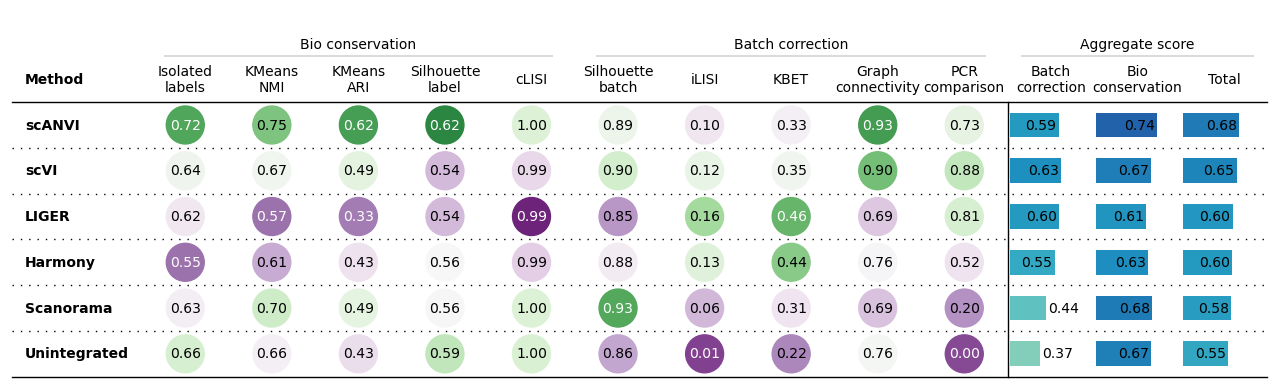

In [ ]:
bm.plot_results_table(min_max_scale=False)

We can also access the underlying dataframes to print the results ourselves.

In [ ]:
from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                            
Unintegrated          0.661278          0.659168          0.427279   
Scanorama             0.626327          0.704883          0.490931   
LIGER                 0.621488          0.570878          0.329819   
Harmony               0.554801          0.606546          0.432499   
scVI                  0.640787          0.673545          0.492218   
scANVI                0.717582          0.747924          0.619476   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegrated          0.585415               1.0          0.855258   
Scanorama             0.564498           0.99961          0.932364   
LIGER                 0.542106           0.98501          0.850703   
Harmony               0.564499          0.993885          0.879939   
scVI                  0.542464          0.994535          0.901744   
scANVI                0.617781          0.999676           0.89006   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegrated          0.008071          0.223801           0.764953   
Scanorama              0.06491          0.313867           0.689019   
LIGER                  0.16332          0.463284           0.694717   
Harmony               0.130198          0.442073           0.756286   
scVI                  0.121231          0.346817           0.896573   
scANVI                0.095208          0.328091           0.932243   
Metric Type   Batch correction  Batch correction   Batch correction   

                PCR comparison Batch correction Bio conservation  \
Embedding                                                          
Unintegrated                 0         0.370417         0.666628   
Scanorama             0.204786         0.440989          0.67725   
LIGER                 0.810099         0.596425          0.60986   
Harmony               0.521999         0.546099         0.630446   
scVI                  0.877328         0.628739          0.66871   
scANVI                 0.72877         0.594875         0.740488   
Metric Type   Batch correction  Aggregate score  Aggregate score   

                        Total  
Embedding                      
Unintegrated         0.548144  
Scanorama            0.582745  
LIGER                0.604486  
Harmony              0.596707  
scVI                 0.652721  
scANVI               0.682242  
Metric Type   Aggregate score

In [ ]:
df.transpose()

Embedding,Unintegrated,Scanorama,LIGER,Harmony,scVI,scANVI,Metric Type
Isolated labels,0.661278,0.626327,0.621488,0.554801,0.640787,0.717582,Bio conservation
KMeans NMI,0.659168,0.704883,0.570878,0.606546,0.673545,0.747924,Bio conservation
KMeans ARI,0.427279,0.490931,0.329819,0.432499,0.492218,0.619476,Bio conservation
Silhouette label,0.585415,0.564498,0.542106,0.564499,0.542464,0.617781,Bio conservation
cLISI,1.0,0.99961,0.98501,0.993885,0.994535,0.999676,Bio conservation
Silhouette batch,0.855258,0.932364,0.850703,0.879939,0.901744,0.89006,Batch correction
iLISI,0.008071,0.06491,0.16332,0.130198,0.121231,0.095208,Batch correction
KBET,0.223801,0.313867,0.463284,0.442073,0.346817,0.328091,Batch correction
Graph connectivity,0.764953,0.689019,0.694717,0.756286,0.896573,0.932243,Batch correction
PCR comparison,0,0.204786,0.810099,0.521999,0.877328,0.72877,Batch correction
